# Exploratoyry Data Analysis

In [11]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, sum as Fsum
from pyspark.sql.types import DoubleType, IntegerType, LongType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation


In [12]:
# Spark Session
spark = SparkSession.builder \
    .appName("YellowTaxiTripPrediction") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

### 1- Columns and variable type

In [ ]:
df = spark.read.parquet("../data/processed.parquet", header=False, inferSchema=True)

df.printSchema()

root
 |-- DOLocationID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- extras: double (nullable = true)
 |-- PU_Borough: string (nullable = true)
 |-- PU_Zone: string (nullable = true)
 |-- DO_Borough: string (nullable = true)
 |-- DO_Zone: string (nullable = true)



### 2- Resume about every column

In [14]:
df.describe().show()

+-------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+----------+--------------------+
|summary|      DOLocationID|      PULocationID|           VendorID|   passenger_count|     trip_distance|      payment_type|       fare_amount|        tip_amount|      total_amount|              hour|       day_of_week|            extras|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|
+-------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+----------+--------------------+
|  count|           3006723|           3006723|            3006723|           2821176|     

2.1 - NA/Null Values

In [15]:
df.select([Fsum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+------------+------------+--------+--------------------+---------------------+---------------+-------------+------------+-----------+----------+------------+----+-----------+------+----------+-------+----------+-------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|payment_type|fare_amount|tip_amount|total_amount|hour|day_of_week|extras|PU_Borough|PU_Zone|DO_Borough|DO_Zone|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+------------+-----------+----------+------------+----+-----------+------+----------+-------+----------+-------+
|           0|           0|       0|                   0|                    0|         185547|            0|           0|          0|         0|           0|   0|          0|185547|         0|      0|         0|      0|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+-------

The **passenger_count** and **extras** columns are the only columns that have null values and they are plenty of them. We will may have to manage that.

### 3- Correlation Matrix

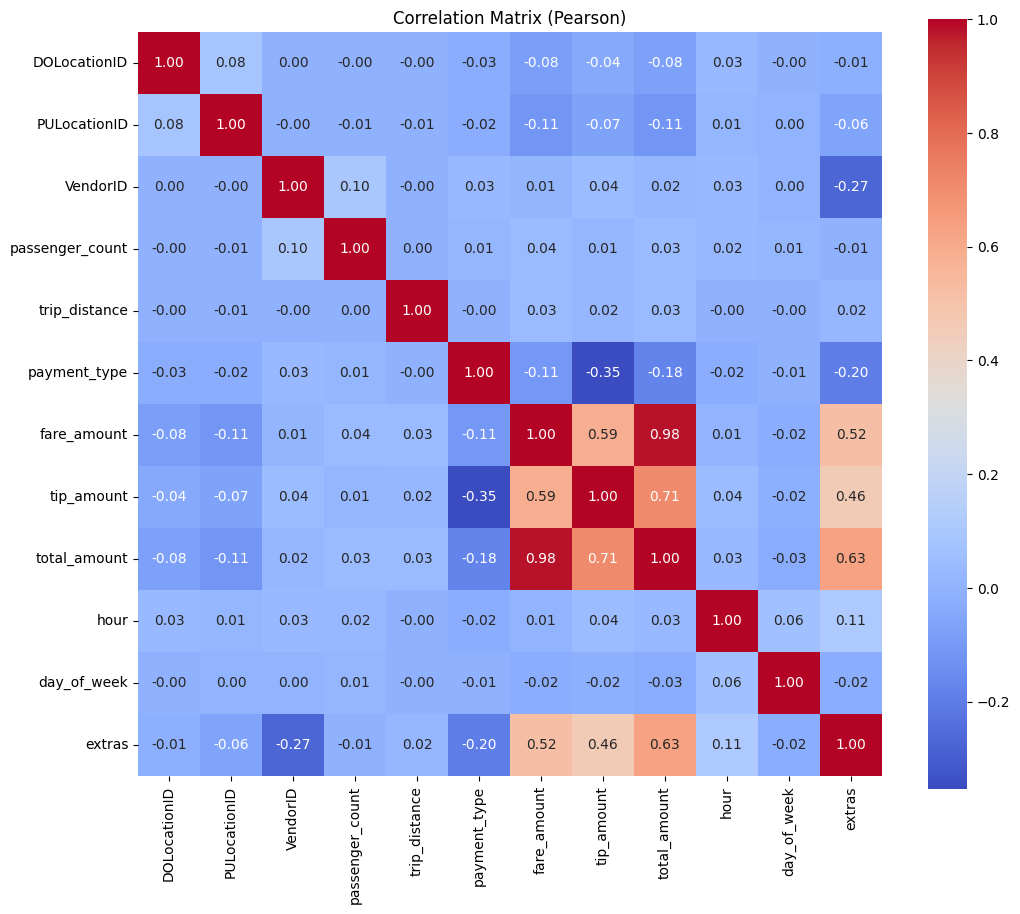

In [16]:
numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType, LongType))]

# Clean NA
df_clean = df.select(numeric_cols).dropna()

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df_clean).select("features")

# Correlation Matrix
corr_matrix = Correlation.corr(df_vector, "features", "pearson").head()[0]
corr_array = corr_matrix.toArray()

corr_df = pd.DataFrame(corr_array, index=numeric_cols, columns=numeric_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Pearson)")
plt.show()

The correlation matrix shows that total_amount is strongly correlated with fare_amount (0.98), trip_distance (0.71), and extras (0.63), which suggests potential data leakage. To build a meaningful predictive model, we should somehow deal with at least **fare_amount** and **tip_amount**, and maybe even **extras** from the features.

We are predicting **total_amount = fare_amount + tip_amount + extras**, and thats why they are so related, so for our model not to use part of the result as input, we may get rid of those features, because it might lead to a proper R² but with a non accurate generalization.